In [3]:
import torch 
import transformers
import matplotlib.pyplot as plt
import dklib.plothelp as ph


In [4]:
#Okay, the goal here will be to load one of the llama models, and then see if we can measure perplexity on a dataset.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print()

def print_gpu_memory_usage():
    print("Memory Usage:")
    print("Allocated:", round(torch.cuda.memory_allocated(0) / 1024**3, 1), "GB")
    print("Cached:   ", round(torch.cuda.memory_reserved(0) / 1024**3, 1), "GB")

# Additional Info when using cuda
if device.type == "cuda":
    print(torch.cuda.get_device_name(0))
    print_gpu_memory_usage()

Using device: cuda

NVIDIA L40S
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [5]:
#okay, let's load the model
from  llama_recipes.inference.model_utils import load_model
model_name = "Llama3.1-8B-Instruct"
model_path = "/work/pcsl/model_weights/llama_hf_weights/"
# quantization = "4bit"
# quantization = "8bit"
quantization = None 
model = load_model(model_path+model_name, quantization, True,model_type = "llama")
model.eval() #put the modeli neval mode.
tokenizer = transformers.AutoTokenizer.from_pretrained(model_path+model_name,device=model.device)
tokenizer.pad_token = tokenizer.eos_token #why are we using this? I think it's because the model is trained with padding as eos tokens.

/home/korchins/miniconda3/envs/llama_nlp/lib/python3.12/site-packages/llama_recipes/model_checkpointing/checkpoint_handler.py:17: DeprecationWarning: `torch.distributed._shard.checkpoint` will be deprecated, use `torch.distributed.checkpoint` instead
  from torch.distributed._shard.checkpoint import (


use_fast_kernelsTrue


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
print_gpu_memory_usage()

Memory Usage:
Allocated: 29.9 GB
Cached:    29.9 GB


In [7]:
# Let's follow the instructions at https://huggingface.co/docs/transformers/perplexity
# from datasets import load_dataset

wiki_duck = " The cinnamon teal (Spatula cyanoptera) is a species of dabbling duck found in western North and South America. It is a migratory species, travelling to northern South America and the Caribbean during the Northern Hemisphere's winter. The cinnamon teal lives in marshes and ponds, and feeds mostly on plants. It has a typical length of 16 in (41 cm), with a wing span of 22 inch (56 cm) and a mass of 14 oz (400 g). The male has bright reddish plumage with a duller brown coloration on the female. The bird feeds predominantly by dabbling, with its main diet being plants and sometimes molluscs and aquatic insects."
encodings = tokenizer(wiki_duck, return_tensors="pt")
encodings = encodings.to(model.device)
# print(encodings)
model.eval()
model_output = model.forward(**encodings,labels = encodings.input_ids.clone())


In [8]:
print('nll: ',model_output.loss,'perplexity = exp(nll) = ',torch.exp(model_output.loss))

nll:  tensor(2.0061, device='cuda:0', grad_fn=<NllLossBackward0>) perplexity = exp(nll) =  tensor(7.4345, device='cuda:0', grad_fn=<ExpBackward0>)


encoding shape:  torch.Size([1, 142])
probabilities shape:  torch.Size([1, 142, 128256])
token # 141 tensor(13, device='cuda:0') --> .  model probability:  tensor(0.8064, device='cuda:0', grad_fn=<SelectBackward0>)  best guess:  .


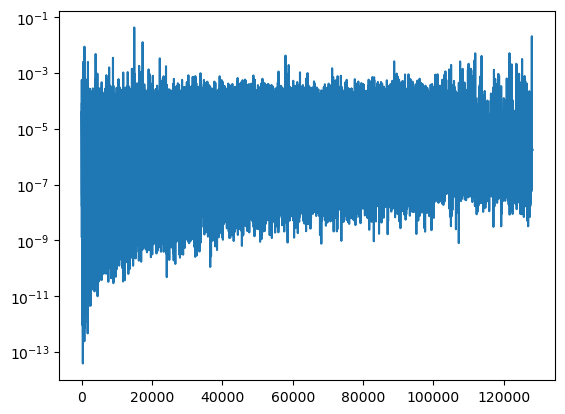

In [9]:
logits = model_output.logits
token_probabilities = logits.softmax(dim=-1)
print("encoding shape: ", encodings.input_ids.shape)
print("probabilities shape: ", token_probabilities.shape)
first_word_probs = token_probabilities[0][0]

def print_token_mapping(sent_ind,token_ind):
    print(
        "token #",token_ind,
        encodings.input_ids[sent_ind][token_ind],
        "-->",
        tokenizer.decode(encodings.input_ids[sent_ind][token_ind]),
        " model probability: ",
        token_probabilities[sent_ind, token_ind-1, encodings.input_ids[sent_ind, token_ind]],
        " best guess: ",
        tokenizer.decode(token_probabilities[sent_ind, token_ind-1].argmax()),
    )
print_token_mapping(0,141) #so, we can see that the token_probabilities [sentence_ind, word_ind,:] are the probabilities of the next token (word_ind+1), given the previous tokens.


fig, ax = plt.subplots()
ax.plot(first_word_probs.cpu().detach().numpy())

ph.logy()

prob_of_actual_tokens shape:  torch.Size([1, 141])
this is one fewer than the number of tokens in the sentence.
This is because we are predicting the next token given the previous ones, 
so we can only test n-1 predictions.
perplexity:  tensor(7.4345, device='cuda:0', grad_fn=<ExpBackward0>)
exponential of model loss:  tensor(7.4345, device='cuda:0', grad_fn=<ExpBackward0>)


Text(0, 0.5, 'Perplexity of first n tokens')

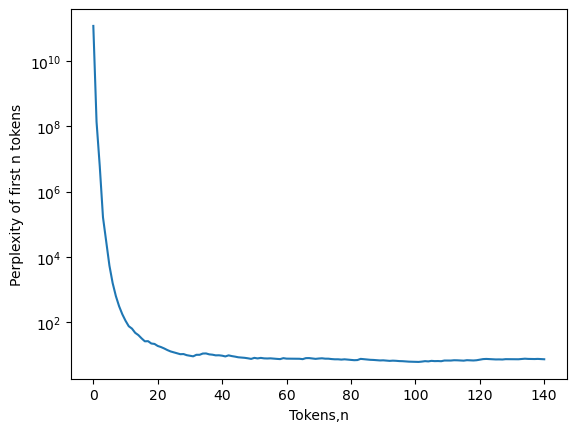

In [10]:
#Can we compute the perplexity of a sentence from the logits?
# torch.mean( token_probabilities )
prob_of_actual_tokens = torch.gather(token_probabilities, 2, encodings.input_ids[:,1:].unsqueeze(-1)).squeeze(-1)
print("prob_of_actual_tokens shape: ", prob_of_actual_tokens.shape)
print("this is one fewer than the number of tokens in the sentence.\nThis is because we are predicting the next token given the previous ones, \nso we can only test n-1 predictions.")
perplexity = torch.exp(-torch.log(prob_of_actual_tokens).mean())
print("perplexity: ", perplexity)
print("exponential of model loss: ",torch.exp(model_output.loss))
#how does the loss vary as the model proceeds through the sentence?
perplexity_n = torch.exp(-torch.cumsum( torch.log(  prob_of_actual_tokens) ,-1) / torch.arange(1,prob_of_actual_tokens.shape[-1]+1,device = prob_of_actual_tokens.device))

fig, ax = plt.subplots(1,1)
ax.plot(perplexity_n.squeeze(0).detach().cpu().numpy())
ph.logy(ax)
ax.set_xlabel('Tokens,n')
ax.set_ylabel('Perplexity of first n tokens')